In [4]:
import tensorflow as tf
import os

# Add this at the very top
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Restrict TensorFlow to only allocate memory dynamically
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

# Load libraries
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import math
import time
from pathlib import Path
from Resnet3D_model import Resnet3DBuilder
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, roc_curve, accuracy_score, recall_score, confusion_matrix
from data_utils_CV import get_paths_and_labels, calculate_min_max, create_dataset, clean_zone_identifier_files, extract_subject_id
from plotting_utils import view_image, view_random_image, plot_loss_curves, make_confusion_matrix, view_image_data
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedGroupKFold
import gc

1 Physical GPUs, 1 Logical GPUs


In [5]:
# Set seeds for reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"Seeds set for reproducibility (seed={seed})")
print(f"PYTHONHASHSEED set to: {os.environ.get('PYTHONHASHSEED')}")

Seeds set for reproducibility (seed=42)
PYTHONHASHSEED set to: 42


In [6]:
# Set mixed precision policy to 'mixed_float16'
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print('Mixed precision policy set to:', policy.name)

Mixed precision policy set to: mixed_float16


In [7]:
NORMALIZATION = "mni_reg_CV" # Choose intensity normalization method: "minmax"
DATASET = "smci_pmci" # Choose dataset: "smci_pmci" or "nc_ad"
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET images
BATCH_SIZE = 4 # Set batch size

USE_MASK = True # Set to True to use the ROI mask, False to use the whole brain

if USE_MASK:
    ROI_MASK_PATH = str(Path("/home/diogommiranda/tese/masks/ROI_MASK.nii"))
else:
    ROI_MASK_PATH = None

# Get train paths and labels to calculate minmax values
train_paths, train_labels_list, class_map = get_paths_and_labels(DATA_DIR, 'train')
train_paths = np.array(train_paths)
train_labels = np.array(train_labels_list)

# Calculate minmax values for train set
minmax_min, minmax_max = calculate_min_max(train_paths)

# Create train dataset
train_data = create_dataset(
    paths=train_paths,
    labels=train_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed,
    min_val=minmax_min, 
    max_val=minmax_max, 
    mask_path=ROI_MASK_PATH
    )

# Create test set with the minmax values from train
test_paths, test_labels, _ = get_paths_and_labels(DATA_DIR, 'test', class_map=class_map)
test_data = create_dataset(
    paths=test_paths,
    labels=test_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=False,
    seed=None,
    min_val=minmax_min, 
    max_val=minmax_max,
    mask_path=ROI_MASK_PATH
    )

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/train...
Found 575 files for class 'smci'
Found 314 files for class 'pmci'
Calculating minmax across 889 files...
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
Shuffling with buffer size: 889

Applying mask from /home/diogommiranda/tese/masks/ROI_MASK.nii

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/test...
Found 143 files for class 'smci'
Found 78 files for class 'pmci'

Applying mask from /home/diogommiranda/tese/masks/ROI_MASK.nii



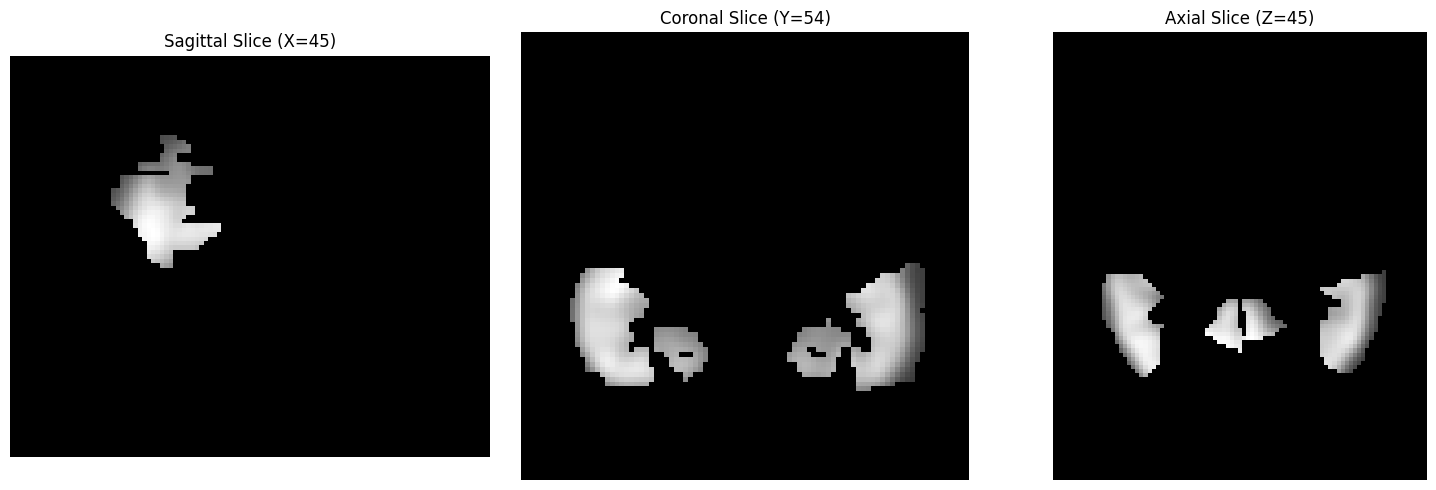

In [8]:
# Verify data with a test sample
for data, label in test_data:
    view_image_data(data[0])
    break

In [ ]:
N_SPLITS = 5 # Number of splits for cross-validation
NUM_EPOCHS = 100 # Number of epochs for training
DROPOUT_RATE = 0.0 # Dropout rate for the model
EARLY_STOP_PATIENCE = 20 # Patience for early stopping (early_stopper)

# para cosine decay
#learning_rates_to_try = [5e-4, 2e-4, 1e-4] # adicionar 1e-3? ver os resultados
#reg_factors_to_try = [5e-4, 2e-4, 1e-4]

#para fixed_lr
#learning_rates_to_try = [1e-5, 2e-5] # adicionar 4e-5 ou 5e-6 dependendo dos resultados
#reg_factors_to_try = [2e-4, 1e-4] # adicionar 4e-4 ou 5e-5 dependendo dos resultados

lr_scheduler = "cosine_decay" # Choose between "cosine_decay" or "fixed_lr"

learning_rates_to_try = [2e-4]
reg_factors_to_try = [1e-4]

tuning_results = []
total_combinations = len(learning_rates_to_try) * len(reg_factors_to_try)
current_combination_no = 0

SAVE_DATA = True # Save training data and plots for each fold and combination

if SAVE_DATA:
    if ROI_MASK_PATH is None:
        if lr_scheduler == "cosine_decay":
            RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/full_brain/cosine_decay/CROSS_VALIDATION/results_resnet34/"
        elif lr_scheduler == "fixed_lr":
            RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/full_brain/fixed_lr/CROSS_VALIDATION/results_resnet34/"
        else:
            raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
        os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
        print(f"Results will be saved to: {RESULTS_BASE_DIR}")
    else:
        if lr_scheduler == "cosine_decay":
            RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/masked/cosine_decay/CROSS_VALIDATION/results_resnet34/"
        elif lr_scheduler == "fixed_lr":
            RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/masked/fixed_lr/CROSS_VALIDATION/results_resnet34/"
        else:
            raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
        os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
        print(f"Results will be saved to: {RESULTS_BASE_DIR}")

# Set up StratifiedGroupKFold by subjects
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
subject_ids_list = [extract_subject_id(p) for p in train_paths]
subject_ids = np.array(subject_ids_list)

print("\nStarting Hyperparameter Tuning Grid Search...")
overall_start_time = time.time()

for current_lr in learning_rates_to_try:
    for current_reg in reg_factors_to_try:
        current_combination_no += 1
        print("=" * 60)
        print(f"Testing Combination {current_combination_no}/{total_combinations}: LR={current_lr:.1e}, L2_Reg={current_reg:.0e}")
        print("=" * 60)
        start_time_combination = time.time()
        
        combo_dir_name = f"LR0_{current_lr:.1e}_L2_{current_reg:.0e}"
        combo_results_dir = os.path.join(RESULTS_BASE_DIR, combo_dir_name)
        os.makedirs(combo_results_dir, exist_ok=True)
        print(f"  Saving results for this combo to: {combo_results_dir}")
        
        # Store results for the current hyperparameter combination
        current_combo_losses = []
        current_combo_accuracies = []
        current_combo_aucs = []
        current_combo_best_epoch = []

        # Store results for each fold
        fold_val_losses = []
        fold_val_accuracies = []
        fold_val_aucs = []
        fold_no = 1

        # K-Fold Cross-Validation
        for train_indices, val_indices in sgkf.split(train_paths, train_labels, groups=subject_ids):
            print("-" * 60)
            print(f"Training Fold {fold_no}/{N_SPLITS} for LR={current_lr:.1e} and Reg={current_reg:.0e}...")
            start_time_fold = time.time()

            # Get the paths and labels for the current fold
            fold_train_paths = train_paths[train_indices]
            fold_train_labels = train_labels[train_indices]
            fold_val_paths = train_paths[val_indices]
            fold_val_labels = train_labels[val_indices]

            # Verify that the training and validation sets have no overlapping subjects
            train_subjects = set(subject_ids[train_indices])
            val_subjects = set(subject_ids[val_indices])
            if not train_subjects.isdisjoint(val_subjects):
                raise RuntimeError(f"WARNING: Fold {fold_no} has overlapping subjects!")
                
            print(f"  Train samples: {len(fold_train_paths)}, Validation samples: {len(fold_val_paths)}")

            # Calculate minmax parameters for the current training fold
            fold_min, fold_max = calculate_min_max(fold_train_paths)

            # Create fold train dataset
            fold_train_data = create_dataset(
                paths=fold_train_paths,
                labels=fold_train_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=True, 
                seed=seed,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )
            
            # Create fold validation dataset
            fold_val_data = create_dataset(
                paths=fold_val_paths,
                labels=fold_val_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False, 
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )

            if fold_train_data is None or fold_val_data is None:
                raise RuntimeError(f"ERROR: Could not create datasets for fold {fold_no}.")

            # Compute class weights for the current fold
            unique_classes, class_counts = np.unique(fold_train_labels, return_counts=True)
            print(f"  Fold train label counts: {dict(zip(unique_classes, class_counts))}")
            fold_class_weights = class_weight.compute_class_weight('balanced', classes=unique_classes, y=fold_train_labels)
            fold_class_weight_dict = dict(zip(unique_classes, fold_class_weights))
            print(f"  Fold Class Weights: {fold_class_weight_dict}")

            tf.keras.backend.clear_session()
            # Build the model
            model = Resnet3DBuilder.build_resnet_34((91, 109, 91, 1), 1, reg_factor=current_reg, dropout_rate=DROPOUT_RATE)
    
            # Cosine decay scheduler
            steps_per_epoch = math.ceil(len(fold_train_data) / BATCH_SIZE)
            decay_steps = steps_per_epoch * NUM_EPOCHS
            COSINE_ALPHA_FACTOR = 1e-6/current_lr # Alpha factor for cosine decay: finishes last epoch (NUM_EPOCHS) in 1e-6
            cosine_decay = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=current_lr,
                                                                     decay_steps=decay_steps,
                                                                     alpha=COSINE_ALPHA_FACTOR,
                                                                     name='CosineDecay')
 
            early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=EARLY_STOP_PATIENCE,
                                                            restore_best_weights=True,
                                                            verbose=1)
    
            callbacks_list = [early_stopper]

            auc_metric = tf.keras.metrics.AUC(name='auc')
            
            if lr_scheduler == "cosine_decay":
                # Use cosine decay
                optimizer_lr = cosine_decay
            elif lr_scheduler == "fixed_lr":
                # Use fixed learning rate
                optimizer_lr = current_lr
            else:
                raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")

            # Compile the model
            model.compile(loss="binary_crossentropy",
                          optimizer= tf.keras.optimizers.Adam(learning_rate=optimizer_lr, clipnorm=1.0),
                          metrics=["accuracy", auc_metric])

            history = model.fit(
                fold_train_data,
                epochs=NUM_EPOCHS,
                validation_data=fold_val_data,
                class_weight=fold_class_weight_dict,
                verbose=1,
                callbacks=callbacks_list
            )
            
            # Save the data for current fold
            if SAVE_DATA:
                fold_dir = os.path.join(combo_results_dir, f"fold_{fold_no}")
                os.makedirs(fold_dir, exist_ok=True)
                history_df = pd.DataFrame(history.history)
                history_df.insert(0, 'epoch', range(1, len(history_df) + 1))
                history_csv_path = os.path.join(fold_dir, f"history_fold_{fold_no}.csv")
                try:
                    history_df.to_csv(history_csv_path, index=False)
                    print(f"  History saved to: {history_csv_path}")
                except Exception as e:
                    print(f"  Error saving history: {e}")
                # Save plots
                plot_loss_curves(history, fold_dir)

            # Evaluate the fold
            best_epoch_index = np.argmin(history.history['val_loss'])
            best_epoch = best_epoch_index + 1
            val_loss_best = history.history['val_loss'][best_epoch_index]
            val_accuracy_best = history.history['val_accuracy'][best_epoch_index]
            val_auc_best = history.history['val_auc'][best_epoch_index]
            print(f"    Fold {fold_no} - Best Epoch {best_epoch}: Val Loss={val_loss_best:.4f}, Acc={val_accuracy_best:.4f}, AUC={val_auc_best:.4f}")
    
            current_combo_losses.append(val_loss_best)
            current_combo_accuracies.append(val_accuracy_best)
            current_combo_aucs.append(val_auc_best)
            current_combo_best_epoch.append(best_epoch)

            # Clean up
            del history_df
            del history 
            del fold_train_data
            del fold_val_data
            del model
            tf.keras.backend.clear_session()
            gc.collect()

            end_time_fold = time.time()
            print(f"    Fold {fold_no} finished in {end_time_fold - start_time_fold:.2f} seconds.")
            fold_no += 1

        # Aggregate results for the current hyperparameter combination
        if len(current_combo_losses) == N_SPLITS:
            avg_loss = np.mean(current_combo_losses)
            std_loss = np.std(current_combo_losses)
            avg_acc = np.mean(current_combo_accuracies)
            std_acc = np.std(current_combo_accuracies)
            avg_auc = np.mean(current_combo_aucs)
            std_auc = np.std(current_combo_aucs)

            print("-" * 50)
            print(f"Results for LR={current_lr}, L2_Reg={current_reg} (Across {N_SPLITS} Folds):")
            print(f"  Avg Val Loss: {avg_loss:.4f} +/- {std_loss:.4f}")
            print(f"  Avg Val Acc:  {avg_acc:.4f} +/- {std_acc:.4f}")
            print(f"  Avg Val AUC:  {avg_auc:.4f} +/- {std_auc:.4f}")
            print("-" * 50)
            

            # Store results
            tuning_results.append({
                'learning_rate': current_lr,
                'reg_factor': current_reg,
                'avg_val_loss': avg_loss,
                'std_val_loss': std_loss,
                'avg_val_accuracy': avg_acc,
                'std_val_accuracy': std_acc,
                'avg_val_auc': avg_auc,
                'std_val_auc': std_auc,
                'individual_losses': [round(loss, 4) for loss in current_combo_losses],
                'individual_accuracies': [round(acc, 4) for acc in current_combo_accuracies],
                'individual_aucs': [round(auc, 4) for auc in current_combo_aucs],
                'best_epoch_per_fold': list(current_combo_best_epoch)
            })

        end_time_combination = time.time()
        print(f"Combination {current_combination_no} finished in {end_time_combination - start_time_combination:.2f} seconds.") 


Results will be saved to: /home/diogommiranda/tese/outputs/masked/cosine_decay/CROSS_VALIDATION/results_resnet34/

Starting Hyperparameter Tuning Grid Search...
Testing Combination 1/1: LR=2.0e-04, L2_Reg=1e-04
  Saving results for this combo to: /home/diogommiranda/tese/outputs/masked/cosine_decay/CROSS_VALIDATION/results_resnet34/LR0_2.0e-04_L2_1e-04
------------------------------------------------------------
Training Fold 1/5 for LR=2.0e-04 and Reg=1e-04...
  Train samples: 706, Validation samples: 183
Calculating minmax across 706 files...
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
Shuffling with buffer size: 706

Applying mask from /home/diogommiranda/tese/masks/ROI_MASK.nii


Applying mask from /home/diogommiranda/tese/masks/ROI_MASK.nii

  Fold train label counts: {0: 456, 1: 250}
  Fold Class Weights: {0: 0.7741228070175439, 1: 1.412}
here CHANNELS last
Epoch 1/100


I0000 00:00:1745790406.619716 1387749 service.cc:145] XLA service 0x7fa2f8001ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745790406.619762 1387749 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-04-27 22:46:49.962994: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-27 22:46:52.772413: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1745790425.326870 1387749 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_32', 536 bytes spill stores, 536 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_31', 404 bytes spill stores, 404 bytes spill loads
ptxas warning : Registers are spilled to local memory i

176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6382 - auc: 0.6612 - loss: 2.2409

In [7]:
print("=" * 60)
if not tuning_results:
    print("No tuning results were recorded.")
else:
    
    results_df = pd.DataFrame(tuning_results)
    results_df = results_df.sort_values(by='avg_val_loss', ascending=False)

    print("\nTuning Results Summary:")
    display_cols = ['learning_rate', 'reg_factor', 'avg_val_loss', 'avg_val_accuracy', 'avg_val_auc', 'std_val_loss', 'std_val_accuracy', 'std_val_auc', 'individual_losses', 'individual_accuracies', 'individual_aucs', 'best_epoch_per_fold']
    print(results_df[display_cols].round(4))

    best_combination = results_df.iloc[0]

    print("\n --- Best Hyperparameters Found ---")
    print(best_combination[display_cols])

    best_lr_final = best_combination['learning_rate']
    best_reg_final = best_combination['reg_factor']
    print(f"\nSelected best parameters: LR={best_lr_final:.1e}, L2_Reg={best_reg_final:.0e}")


Tuning Results Summary:
   learning_rate  reg_factor  avg_val_loss  avg_val_accuracy  avg_val_auc  \
0            0.0      0.0002        1.4229            0.8034       0.8438   

   std_val_loss  std_val_accuracy  std_val_auc  \
0        0.2951            0.0632       0.0686   

                          individual_losses  \
0  [2.0009, 1.2823, 1.1768, 1.2914, 1.3629]   

                     individual_accuracies  \
0  [0.7104, 0.875, 0.8729, 0.7898, 0.7688]   

                           individual_aucs   best_epoch_per_fold  
0  [0.7199, 0.8827, 0.922, 0.8313, 0.8634]  [75, 99, 71, 85, 93]  

 --- Best Hyperparameters Found ---
learning_rate                                            0.000011
reg_factor                                                 0.0002
avg_val_loss                                             1.422863
avg_val_accuracy                                         0.803374
avg_val_auc                                              0.843841
std_val_loss                  

# --- Train the model with the best hyperparameters and evaluate it on the test set ---

In [6]:
if ROI_MASK_PATH is None:
    print("\nUsing full brain scan.\n")
else:
    print("\nUsing ROI mask.\n")


Using ROI mask.



here CHANNELS last

Using cosine decay.

  Class Weights: {0: 0.7730434782608696, 1: 1.4156050955414012}
Epoch 1/30


I0000 00:00:1745788569.742970 1359676 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_366__5', 12 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_354__8', 2424 bytes spill stores, 2376 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm70_shflsync_down', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_336__7', 1828 bytes spill stores, 1680 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm70_shflsync_down', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_convert_reduce_fusion_16', 204 bytes spill stores, 204 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion

221/223 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6833 - auc: 0.7132 - loss: 2.9682

I0000 00:00:1745788601.160619 1359676 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_372__5', 12 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_359__8', 2424 bytes spill stores, 2376 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm70_shflsync_down', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_34', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_342__7', 1828 bytes spill stores, 1680 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm70_shflsync_down', 8 bytes spill stores, 8 bytes spill loads



223/223 ━━━━━━━━━━━━━━━━━━━━ 80s 144ms/step - accuracy: 0.6833 - auc: 0.7132 - loss: 2.9602
Epoch 2/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.6451 - auc: 0.6708 - loss: 1.4811
Epoch 3/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.7164 - auc: 0.7743 - loss: 1.1101
Epoch 4/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.7510 - auc: 0.8127 - loss: 0.9256
Epoch 5/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.7514 - auc: 0.8027 - loss: 0.8859
Epoch 6/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.7782 - auc: 0.8247 - loss: 0.8129
Epoch 7/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.7568 - auc: 0.8063 - loss: 0.8125
Epoch 8/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.7718 - auc: 0.8295 - loss: 0.7677
Epoch 9/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.7932 - auc: 0.8469 - loss: 0.7216
Epoch 10/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.8055 - auc: 0.8784 - lo

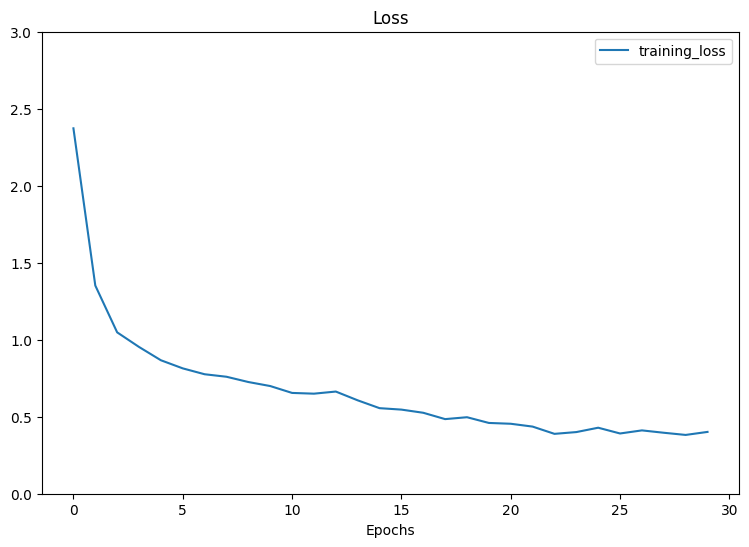

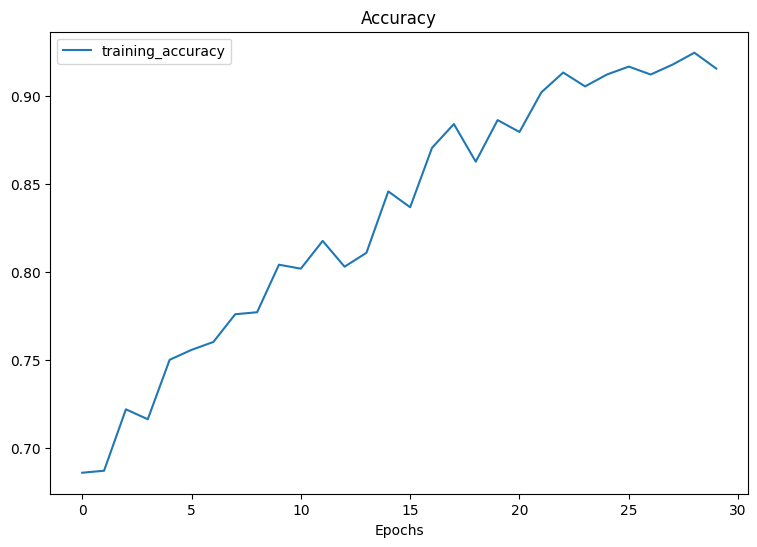

In [10]:
# --- Train the model with the best hyperparameters and evaluate it on the test set ---

cosine_scheduler = True # Set to True if using cosine decay, False if using fixed learning rate

# Hyperparameters to tune
BEST_LR = 4e-4 # learning rate
BEST_REG= 2e-4 # l2 regularization factor
BEST_NUM_EPOCHS = 30 # number of epochs for training

# Cosine decay parameters
DECAY_STEPS_TO_USE = math.ceil(len(train_data) / BATCH_SIZE) * 100 # 100 epochs (used in cross-validation for cosine decay)
BEST_ALPHA_FACTOR =  1e-6 / BEST_LR
DROPOUT_RATE = 0.0
cosine_decay = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=BEST_LR,
                                                        decay_steps=DECAY_STEPS_TO_USE,
                                                        alpha=BEST_ALPHA_FACTOR,
                                                        name='CosineDecay')


model = Resnet3DBuilder.build_resnet_34((91, 109, 91, 1), 1, reg_factor=BEST_REG, dropout_rate=DROPOUT_RATE)
#model = tf.keras.models.load_model("/home/diogommiranda/tese/outputs/best_model.keras") # load model to continue training for more epochs

if cosine_scheduler:
    # Use cosine decay
    optimizer_lr = cosine_decay
    print(f"\nUsing cosine decay.\n")
else:
    # Use fixed learning rate
    optimizer_lr = BEST_LR
    print(f"\nUsing fixed learning rate: {BEST_LR}\n")

auc_metric = tf.keras.metrics.AUC(name='auc')

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=optimizer_lr,
                                                     clipnorm=1.0),
                metrics=["accuracy", auc_metric])


# Only save the model if not using cosine decay
if not cosine_scheduler:
    check_point_filepath = "/home/diogommiranda/tese/outputs/best_model.keras"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=check_point_filepath,
        monitor='loss',
        mode='min',
        save_best_only=False)
    callbacks = [model_checkpoint_callback]
else:
    callbacks = None

# Compute class weights
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
class_weights = class_weight.compute_class_weight('balanced', classes=unique_classes, y=train_labels)
class_weight_dict = dict(zip(unique_classes, class_weights))
print(f"  Class Weights: {class_weight_dict}")

history = model.fit(
    train_data,
    epochs=BEST_NUM_EPOCHS,
    class_weight=class_weight_dict,
    verbose=1,
    callbacks=callbacks,
)

# Plot loss and accuracy curves
plot_loss_curves(history)

result = model.evaluate(test_data, return_dict=True)
print(f"[{result['loss']}, {result['accuracy']}]")


56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step


2025-04-27 21:33:30.782491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



--- Evaluation Metrics on Test Set ---
Accuracy:    0.7602
Sensitivity: 0.6282
Specificity: 0.8322 
Balanced Accuracy (BACC): 0.7302
F1 Score (Weighted):      0.7583
Matthews Corr Coef (MCC): 0.4678
Area Under the Curve (AUC): 0.8063



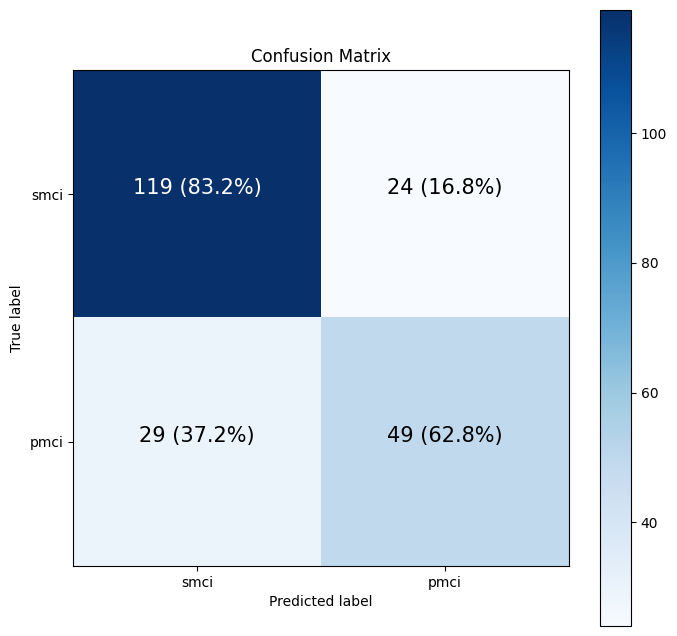

In [ ]:
# Predict on the test set
y_pred = model.predict(test_data).flatten()

# --- Print evaluation metrics ---
y_true = []
test_samples = []
for sample, label in test_data.as_numpy_iterator():
    test_samples.append(sample)
    y_true.append(label)
y_true = np.concatenate(y_true)


test_samples = np.concatenate(test_samples, axis=0)
y_true_int = y_true.astype(int)
y_pred_int = y_pred.round().astype(int)

accuracy = accuracy_score(y_true_int, y_pred_int)
sensitivity = recall_score(y_true_int, y_pred_int, pos_label=1)
specificity = recall_score(y_true_int, y_pred_int, pos_label=0)
bacc = balanced_accuracy_score(y_true_int, y_pred_int)
f1 = f1_score(y_true_int, y_pred_int, average='weighted')
mcc = matthews_corrcoef(y_true_int, y_pred_int)

auc_score = result.get('auc')

print(f"\n--- Evaluation Metrics on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f} ")
print(f"Balanced Accuracy (BACC): {bacc:.4f}")
print(f"F1 Score (Weighted):      {f1:.4f}") 
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

# --- Plot confusion matrix ---
class0, class1 = DATASET.split("_")
target_names = [class0, class1]

make_confusion_matrix(y_true=y_true,
                      y_pred=y_pred.round(),
                      classes=target_names,
                      figsize=(8, 8),
                      text_size=15)



# Save the model

In [ ]:
save_option = False # Set to True to save the model, confusion matrix, and evaluation metrics

if save_option:
    
    # Configure the right path
    if USE_MASK:
        dir1 = "masked/"
    else:
        dir1 = "full_brain/"
    if cosine_scheduler:
        dir2 = "cosine_decay/"
    else:
        dir2 = "fixed_lr/"
        
    save_model_dir = "/home/diogommiranda/tese/outputs/" + dir1 + dir2 + "CROSS_VALIDATION/saved_models/" + f"LR={BEST_LR:.1e}_L2={BEST_REG:.0e}"
    print(f"Saving model to: {save_model_dir}")
    os.makedirs(save_model_dir, exist_ok=True)

    # Save the model
    model.save(os.path.join(save_model_dir, "model.keras"))

    # Save the confusion matrix plot
    make_confusion_matrix(y_true=y_true,
                        y_pred=y_pred.round(),
                        classes=target_names,
                        figsize=(8, 8),
                        text_size=15,
                        save_dir=save_model_dir)

    # Save the test loss and accuracy and the evaluation metrics
    result_file_path = os.path.join(save_model_dir, "resultados.txt")
    with open(result_file_path, "w") as f:
        f.write(f"Test loss and Accuracy:   [{result['loss']}, {result['accuracy']}]\n\n")
        f.write("--- Evaluation Metrics on Test Set ---\n")
        f.write(f"Accuracy:    {accuracy:.4f}\n")
        f.write(f"Sensitivity: {sensitivity:.4f}\n")
        f.write(f"Specificity: {specificity:.4f}\n")
        f.write(f"Balanced Accuracy (BACC): {bacc:.4f}\n")
        f.write(f"F1 Score (Weighted):      {f1:.4f}\n")
        f.write(f"Matthews Corr Coef (MCC): {mcc:.4f}\n")
        f.write(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

Saving model to: /home/diogommiranda/tese/outputs/masked/cosine_decay/CROSS_VALIDATION/saved_models/LR=2.0e-04_L2=2e-04


In [ ]:
#saved_model = tf.keras.models.load_model("/home/diogommiranda/tese/outputs/full_brain/fixed_lr/CROSS_VALIDATION/saved_models/LR=1.1e-5 L2=2e-4/model.keras")

In [ ]:
#result = saved_model.evaluate(test_data, return_dict=True)
#print(f"[{result['loss']}, {result['accuracy']}]")


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.8917 - auc: 0.3368 - loss: 1.7163
[1.964396357536316, 0.8461538553237915]
